In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [6]:
def findRoads(image, model=None, num_classes=2, num_pyramids=2,
                cnn_run_params=None, cnn_creation_params=None, device="cuda",
                model_checkpoint=f"{data_dir}/FANN/checkpoint_101023.pth"):
    
    if cnn_run_params is None:
        cnn_run_params = {
            "tilesize"   : 2048,
            "edges"      : 0,
            "dims_rep"   : None,
            "n_pyramids" : num_pyramids,
            "num_dim"    : num_classes,
            "device"     : device
        }
    
    if cnn_creation_params is None:
        cnn_creation_params = {
            "num_classes" : num_classes,
            "inputsize"   : num_pyramids,
        }
    
    # Input handling
    if isinstance(image, np.ndarray):
        image = [image] # Make iterable if needed
    
    # Initialize model if needed
    if model is None:
        model = TPNN(**cnn_creation_params)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to(device)
    
    # PROCESS IMAGE
    for im in image:
        outputs, _ = split_and_run_cnn(im, model, **cnn_run_params)
    
    # background, grid, roads = outputs[:, :, 0], outputs[:, :, 1], outputs[:, :, 2]
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    outputs = outputs * 255
    outputs = outputs.astype(np.uint8)
    
    # return (background.T, grid.T, roads.T), model
    return outputs, model


def get_all_image_paths(directory, image_extensions=['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff', '*.tif']):
    """
    Recursively finds all image files in the given directory and its subdirectories.
    
    :param directory: The root directory to start the search from.
    :param image_extensions: A list of image file extensions to look for.
    :return: A list of full file paths to the images found.
    """
    image_paths = []
    
    # Loop through each extension in the list
    for extension in image_extensions:
        # Use glob to find all files matching the extension, recursively
        image_paths.extend(glob.glob(os.path.join(directory, '**', extension), recursive=True))
    
    return image_paths

def findBounds(image_fn, model=None, 
        model_weights=f"{data_dir}RLNN/weights050124.pt",
        creation_params=None,
        device="cpu",
        ):
    
    if creation_params is None:
        target_size = 512
        original_shapes = []

        # COCO DATASET PARAMS
        category_labels = {
            0 : "County",
            1 : "Tile",
            2 : "Box",
            3 : "Legend"
        }

        categories=[0, 1]

    input_folder = os.path.dirname(os.path.abspath(image_fn))

    # Initialize model
    if model is None:
        model = ultralytics.YOLO(model_weights).to("cpu")

    model = model.to(device)
    
    results = model(image_fn, imgsz=target_size)

    return results, model

def findStreetCorners(image_fn, FANN=None, RLNN=None):
    image = np.asarray(Image.open(image_fn))

    if image.ndim == 3:
        image = image[:, :, 0]

    # RUN CNN
    out, FANN = findRoads(image, model=FANN)

    # RUN YOLO
    outbbox, RLNN = findBounds(image_fn)

    # REMOVE ANY CNN OUTSIDE BOUNDS
    bounds = outbbox[0].boxes.xyxy.numpy().astype(np.int32).flatten()
    mask  = np.zeros(out.shape)
    if False:# len(bounds) > 0:
        mask[bounds[1]:bounds[3], bounds[0]:bounds[2], :] = 1

    if np.sum(mask) == 0:
        mask = mask + 1
    out = out * mask
    out = out.astype(np.uint8)

    curr_bounds = mask * 255
    curr_bounds = curr_bounds.astype(np.uint8)

    if np.max(image) < 255:
        image = 255 * image
        image = image.astype(np.uint8)

    print(image.shape, out.shape, curr_bounds.shape)
    test = np.dstack((image, out[:, :, 1], curr_bounds[:, :, 0]))
    
    return test, FANN, RLNN

# image_fns = get_all_image_paths(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\FANN\YOLO_dataset\images")
image_fns = get_all_image_paths(r"D:\RECTDNN\YOLO\datasets\TPNNv4\images\")
images    = [np.asarray(Image.open(fn)) for fn in image_fns]

In [10]:
FANN = None
RLNN = None

roads_list = []
bound_list = []

for i, image in enumerate(images):

    if np.max(image) < 255:
        image = 255 * image
        image = image.astype(np.uint8)
    print(image.max())
    # RUN CNN
    out, FANN = findRoads(image, model=FANN)

    # RUN YOLO
    outbbox, RLNN = findBounds(image_fns[i])

    # REMOVE ANY CNN OUTSIDE BOUNDS
    bounds = outbbox[0].boxes.xyxy.numpy().astype(np.int32).flatten()
    mask  = np.zeros(out.shape)
    if False:# len(bounds) > 0:
        mask[bounds[1]:bounds[3], bounds[0]:bounds[2], :] = 1

    if np.sum(mask) == 0:
        mask = mask + 1
    out = out * mask
    out = out.astype(np.uint8)

    roads_list.append(out)
    bound_list.append(mask)

255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\4802870335E.jpg: 384x512 1 bounds, 201.0ms
Speed: 2.0ms preprocess, 201.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\4854560015B.jpg: 512x384 (no detections), 221.2ms
Speed: 2.0ms preprocess, 221.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 384)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\train\4802870335E.jpg: 384x512 1 bounds, 190.8ms
Speed: 2.0ms preprocess, 190.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\train\4854560015B.jpg: 512x384 (no detections), 199.9ms
Speed: 2.0ms preprocess, 199.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 384)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\480035A_30.tif: 352x512 1 bounds, 231.9ms
Speed: 2.0ms preprocess, 231.9ms inference, 7.1ms postprocess per image at shape (1, 3, 352, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0140G.tif: 384x512 1 bounds, 201.3ms
Speed: 5.1ms preprocess, 201.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0160G.tif: 384x512 1 bounds, 196.7ms
Speed: 3.0ms preprocess, 196.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0170G.tif: 384x512 1 bounds, 215.9ms
Speed: 3.0ms preprocess, 215.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0295L.tif: 384x512 1 bounds, 221.3ms
Speed: 4.0ms preprocess, 221.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0300G.tif: 384x512 1 bounds, 512.1ms
Speed: 16.0ms preprocess, 512.1ms inference, 86.2ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0415L.tif: 384x512 1 bounds, 204.7ms
Speed: 5.0ms preprocess, 204.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/5 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\48201C0865J.tif: 448x512 1 bounds, 304.8ms
Speed: 11.3ms preprocess, 304.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 512)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\485469B_6.tif: 352x512 1 bounds, 179.3ms
Speed: 3.0ms preprocess, 179.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 512)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\all\485491C_2.tif: 352x512 1 bounds, 180.1ms
Speed: 2.0ms preprocess, 180.1ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 512)
255


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\train\480035A_30.tif: 352x512 1 bounds, 191.2ms
Speed: 2.0ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]


image 1/1 D:\RECTDNN\YOLO\datasets\TPNNv4\images\train\48201C0140G.tif: 384x512 1 bounds, 225.9ms
Speed: 3.0ms preprocess, 225.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 512)
255


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

255 255 255
(3766, 5462) (3766, 5462, 2) (3766, 5462, 2)


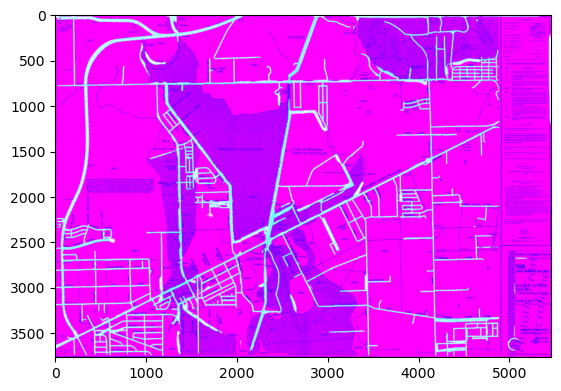

255 255 255
(3768, 2671) (3768, 2671, 2) (3768, 2671, 2)


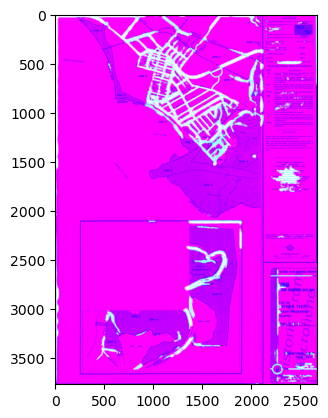

255 255 255
(3766, 5462) (3766, 5462, 2) (3766, 5462, 2)


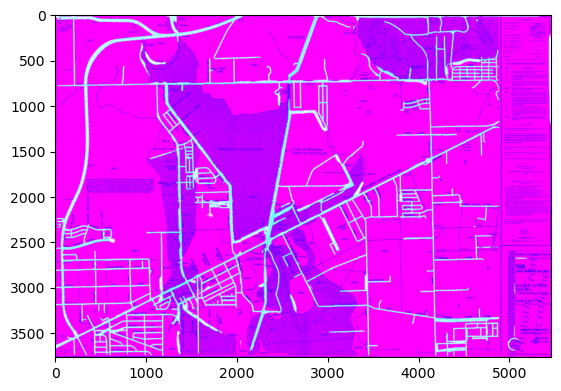

255 255 255
(3768, 2671) (3768, 2671, 2) (3768, 2671, 2)


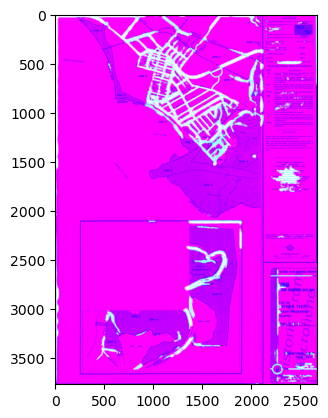

255 255 255
(2836, 4457) (2836, 4457, 2) (2836, 4457, 2)


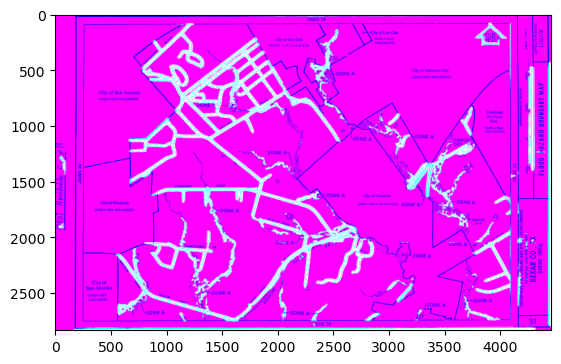

255 255 255
(10280, 14833) (10280, 14833, 2) (10280, 14833, 2)


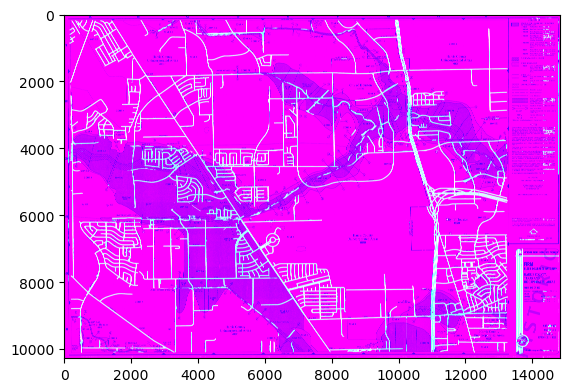

255 255 255
(10247, 14867) (10247, 14867, 2) (10247, 14867, 2)


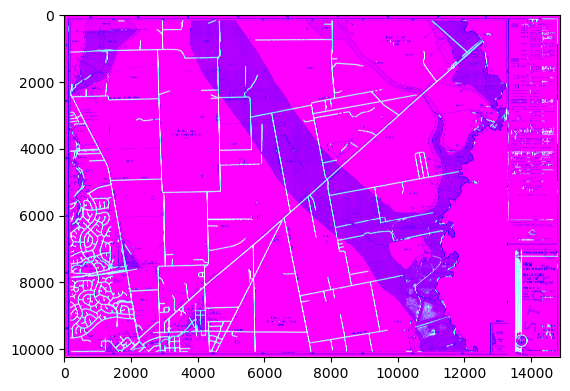

255 255 255
(10253, 14846) (10253, 14846, 2) (10253, 14846, 2)


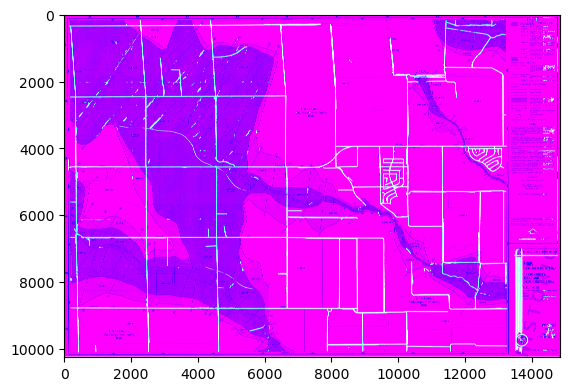

255 255 255
(10259, 14200) (10259, 14200, 2) (10259, 14200, 2)


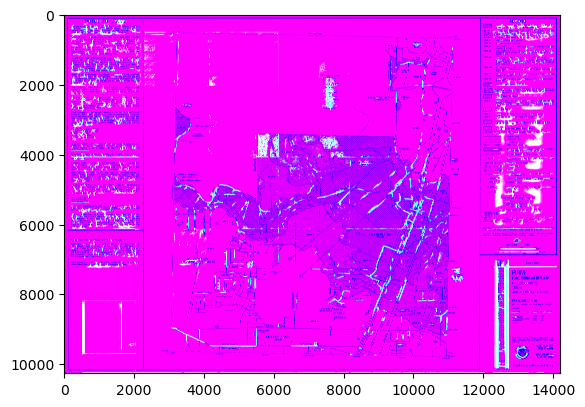

255 255 255
(10250, 14867) (10250, 14867, 2) (10250, 14867, 2)


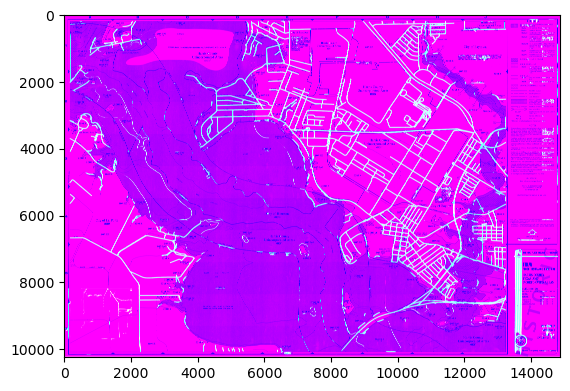

255 255 255
(10267, 14184) (10267, 14184, 2) (10267, 14184, 2)


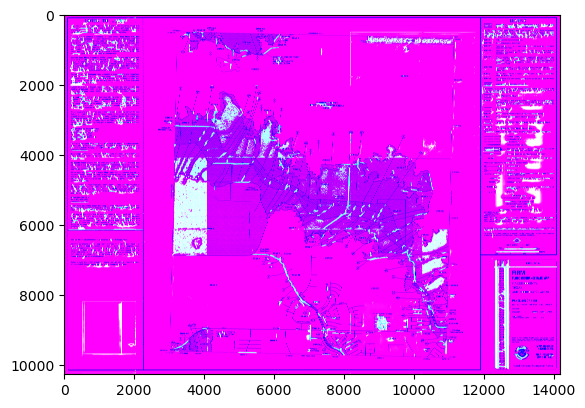

255 255 255
(10227, 11800) (10227, 11800, 2) (10227, 11800, 2)


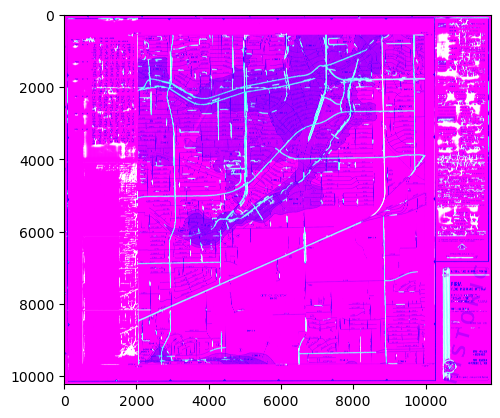

255 255 255
(2807, 4161) (2807, 4161, 2) (2807, 4161, 2)


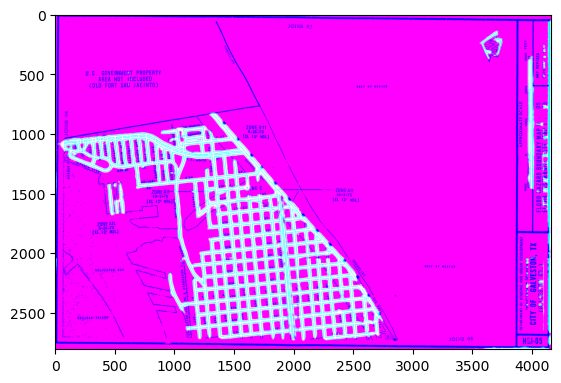

255 255 255
(2997, 4551) (2997, 4551, 2) (2997, 4551, 2)


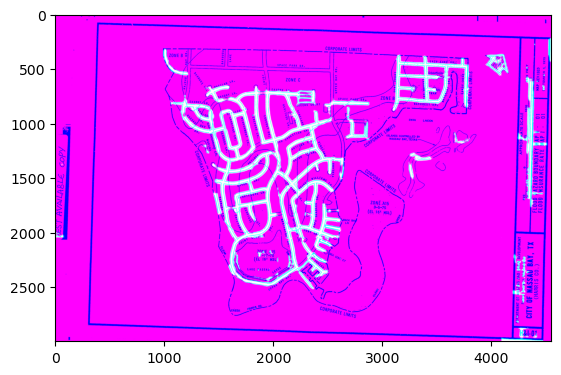

255 255 255
(2836, 4457) (2836, 4457, 2) (2836, 4457, 2)


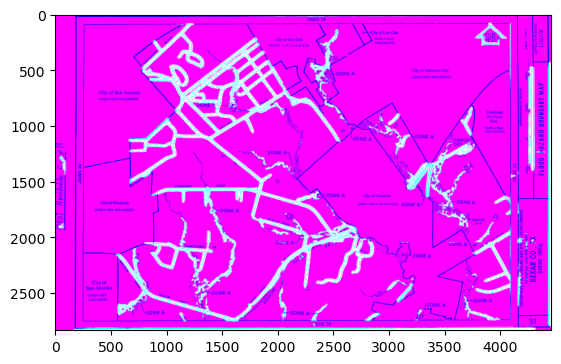

255 255 255
(10280, 14833) (10280, 14833, 2) (10280, 14833, 2)


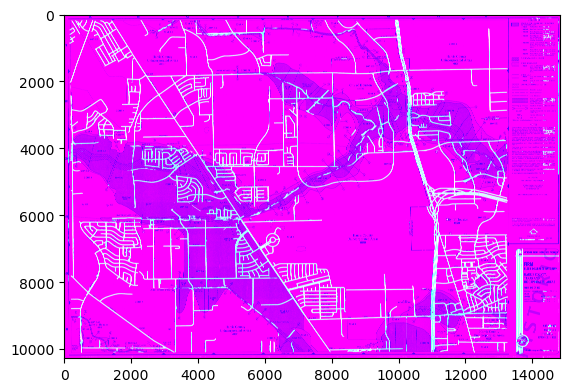

In [12]:
outputs = []

for i in range(len(bound_list)):
    curr_bounds = bound_list[i] * 255
    curr_bounds = curr_bounds.astype(np.uint8)

    image = images[i]
    if np.max(image) < 255:
        image = 255 * image
        image = image.astype(np.uint8)

    print(np.max(image), np.max(roads_list[i][:, :, 1]), np.max(curr_bounds))
    print(images[i].shape, roads_list[i].shape, curr_bounds.shape)
    test = np.dstack((image, roads_list[i][:, :, 1], curr_bounds[:, :, 0]))
    
    plt.imshow(test)
    plt.show()
    outputs.append(test)
    Image.fromarray(test).save(image_fns[i])


In [31]:
test.shape

(3766, 5462, 3)

In [35]:
test[:, :, 2].max()

1